# Forecasting

### Student: Rodolfo Lerma

In this assignment, we will explore the python package [statsmodels](http://www.statsmodels.org/dev/tsa.html) to forecast the time series data. You will learn to use different time series modeling technique for forecasting.

Learning Objectives:

- Decompose time series into autocorrelation, seasonality, trend, and noise. 
- Explain the effects of exponential smoothing models and differentiate them from other models.
- Apply and evaluate the results of an autoregressive model. 
- Apply and evaluate the results of a moving average model. 
- Apply and evaluate the results of an autoregressive integrated moving average model.
- Apply and evaluate the results of ARIMA model for forecasting (time series prediction).


In [1]:
# # install packages
# import sys
# !pip3 install --prefix {sys.prefix} statsmodels

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

----------

## Air Passenger Dataset
This dataset provides monthly totals of international airline passengers from 1949 to 1960. You can find a copy of the dataset on [Kaggle](https://www.kaggle.com/rakannimer/air-passengers) or [R datasets](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html).

In [3]:
df = pd.read_csv('./airline-passengers.csv', index_col=[0], parse_dates=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df= df.rename(columns={'airline passengers': 'passengers'})
df.head()

,passengers
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.tail()

,passengers
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


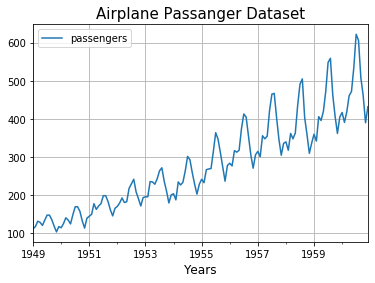

In [5]:
# split the data into train and test
train, test = df.iloc[:130, [0]], df.iloc[130:, [0]]

df.plot()
pyplot.title('Airplane Passanger Dataset', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

As it is possible to see the data set contains monthly Airplane Passanger Data from **1949** to **1960**.

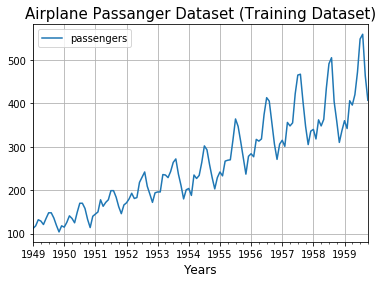

In [6]:
train.plot()
pyplot.title('Airplane Passanger Dataset (Training Dataset)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

In [7]:
train.shape

(130, 1)

The train data set contains 130 entries

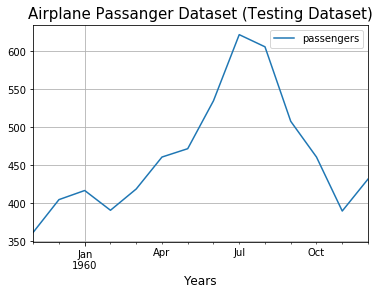

In [8]:
test.plot()
pyplot.title('Airplane Passanger Dataset (Testing Dataset)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.show()

In [9]:
test.shape

(14, 1)

The test data set have 14 datapoints which reflect the last 14 months.

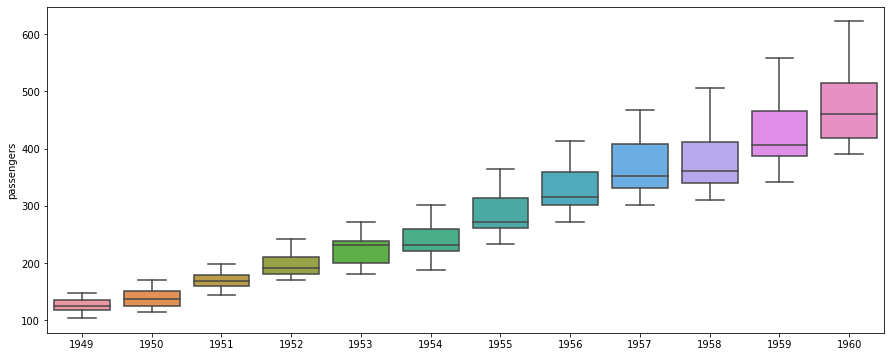

In [10]:
import seaborn as sns
fig, ax = pyplot.subplots(figsize=(15,6))
sns.boxplot(df.passengers.index.year, df.passengers, ax=ax)

As shown by this plot we can see how the variation and mean are growing every year.

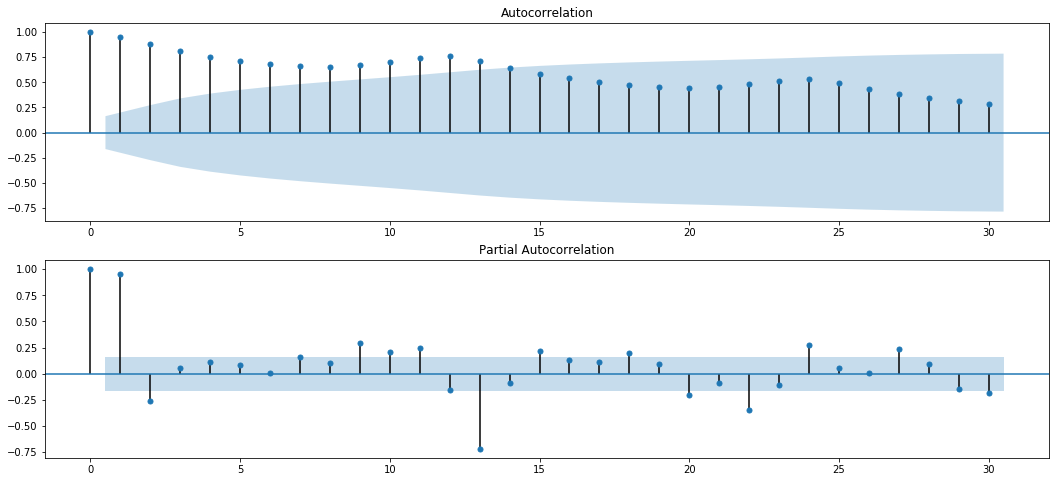

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
pyplot.figure()
pyplot.subplot(211)
plot_acf(df.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(df.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

It is possible to notice that the data is Non-stationary, as the future observations are correlated to previous values.

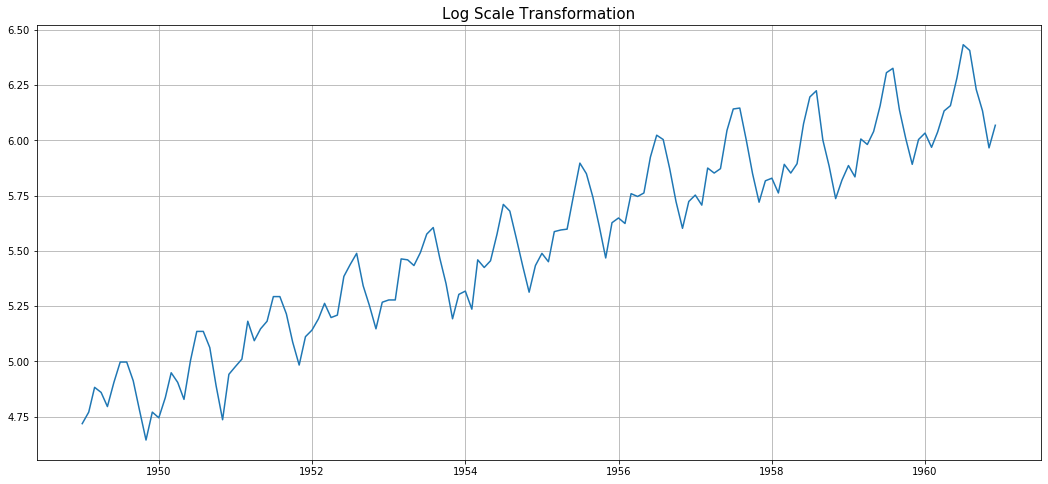

In [12]:
ts_log = np.log(df)
pyplot.plot(ts_log)
pyplot.title('Log Scale Transformation', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

The log transformation helps on reducing the grow of the variation seen in the original data.

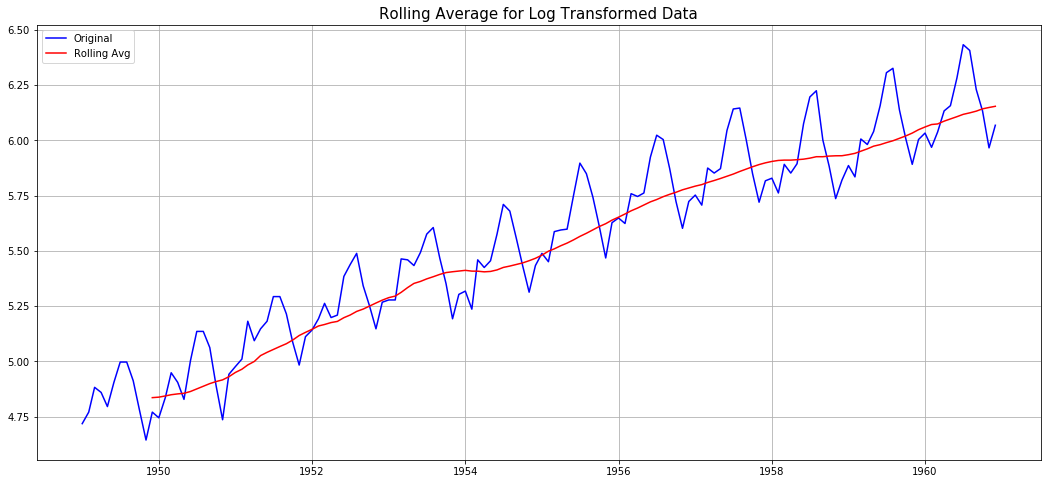

In [13]:
#Determing rolling statistics
rolmean = ts_log.rolling(12).mean()

#Plot rolling statistics:
orig = pyplot.plot(ts_log, color='blue',label='Original')
mean = pyplot.plot(rolmean, color='red', label='Rolling Avg')
pyplot.legend(loc='best')
pyplot.title('Rolling Average for Log Transformed Data', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

In [14]:
ts_log_moving_avg_diff = ts_log - rolmean

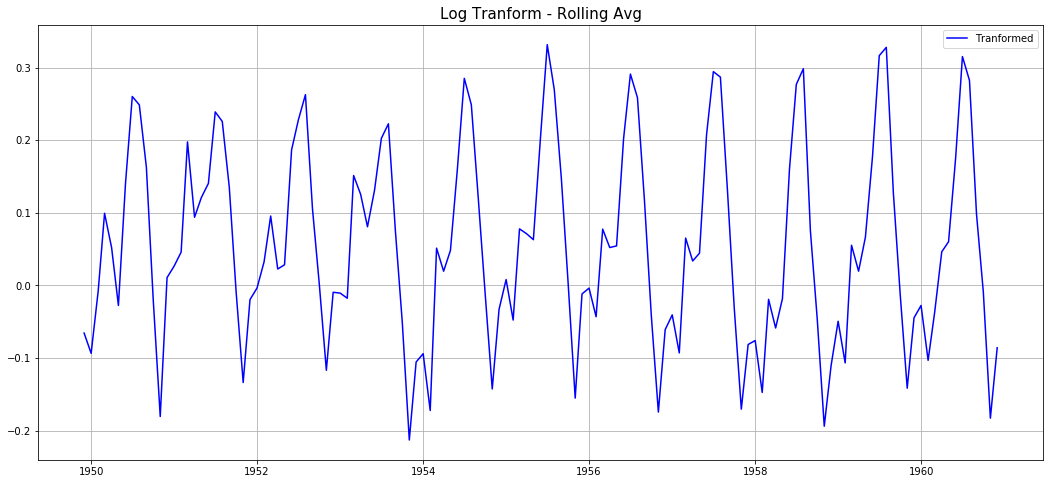

In [15]:
orig = pyplot.plot(ts_log_moving_avg_diff, color='blue',label='Tranformed')
#mean = pyplot.plot(rolmean, color='red', label='Rolling Avg')
pyplot.legend(loc='best')
pyplot.title('Log Tranform - Rolling Avg', fontsize = 15)
pyplot.grid()
pyplot.show(block=False)

The log transformation reduces the change of the variation of the data as it grows thru time.

### Question 1.1: Using [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) API from `statsmodels.tsa.seasonal`, apply additive decomposition to the airline passenger dataset and plot each components from the decomposition.

Decomposition of Original Data Set: Additive


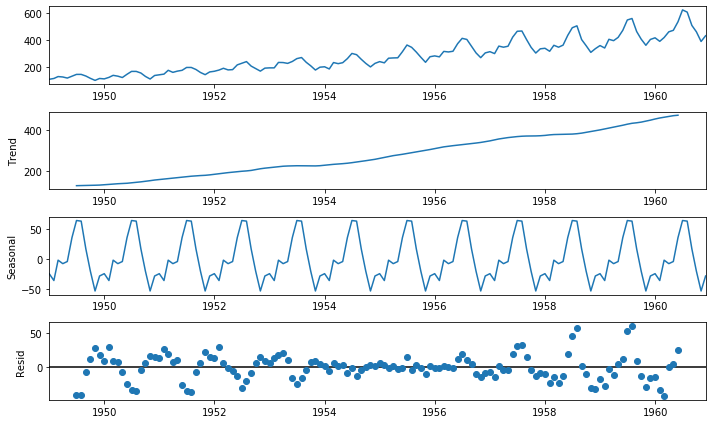

In [16]:
# additive decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
test_size = test.shape[0]
print('Decomposition of Original Data Set: Additive')
rcParams['figure.figsize'] = 10, 6
result = seasonal_decompose(df, model='additive')
fig = result.plot()
pyplot.show()

### Question 1.2: Using [seasonal_decompose](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) API from `statsmodels.tsa.seasonal`, apply multiplication decomposition to the same airline passenger dataset and plot each components from the decomposition. Which decomposition makes more sense in this dataset? 

Decomposition of Original Data Set: Multiplicative


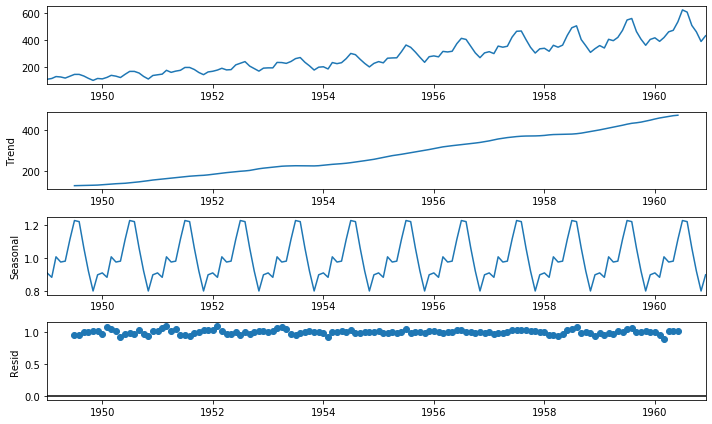

In [17]:
# multiplicative decomposition
print('Decomposition of Original Data Set: Multiplicative')
rcParams['figure.figsize'] = 10, 6
results = seasonal_decompose(df, model='multiplicative')
fig = results.plot()
pyplot.show()

### 1.3: Decompostion of the Log Transform data set

Decomposition of Log Transform Dataset


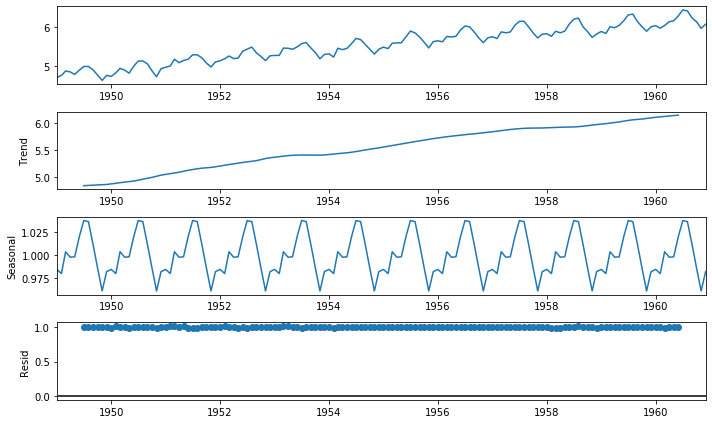

In [18]:
# Log Transform decomposition
print('Decomposition of Log Transform Dataset')
rcParams['figure.figsize'] = 10, 6
result = seasonal_decompose(ts_log, model='multiplicative')
fig = result.plot()
pyplot.show()

### Notes:

- It is possible to see that the "Additive" method still show signs of seasonality.
- The "Multiplicative" method looks better, but more investigation needs to be done as all the values are around 1.
- Same is seen even when the data is transformed using a Log transformation.

In [19]:
train_log, test_log = ts_log.iloc[:130, [0]], ts_log.iloc[130:, [0]]

In [20]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
train_logm, test_logm = ts_log_diff.iloc[:130, [0]], ts_log_diff.iloc[130:, [0]]

----------

### Question 2.1: Apply the simple exponential smoothing technique ([SimpleExpSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameter `smoothing_level` and see how it impacts the model accuracy. 

In [21]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [22]:
#Alpha = 0.2
fit1 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=1, 
                                                                 optimized=False)
fcast1 = fit1.forecast(test_size).rename(r"$\alpha=0.2$")

#Alpha = 0.6                                                                 
fit2 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.6, 
                                                                 optimized=False)
fcast2 = fit2.forecast(test_size).rename(r"$\alpha=0.6$")

#Alpha = 0.8                                                                   
fit3 = SimpleExpSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.8, 
                                                                 optimized=False)
fcast3 = fit3.forecast(test_size).rename(r"$\alpha=0.8$")

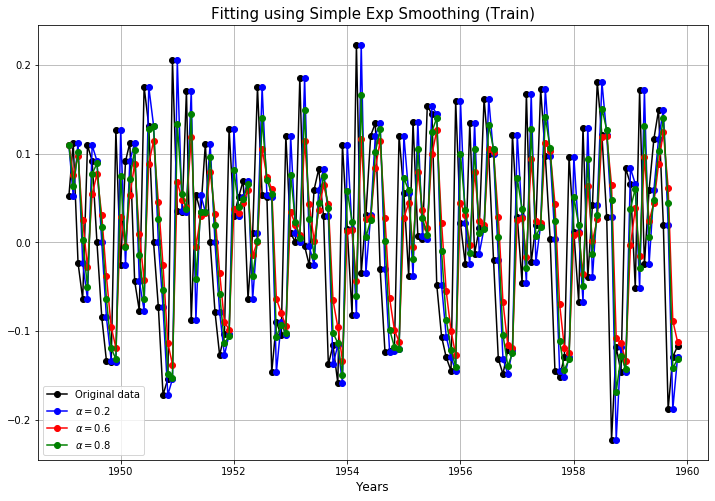

In [23]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(fit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.2$")
pyplot.plot(fit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
pyplot.plot(fit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
pyplot.title('Fitting using Simple Exp Smoothing (Train)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

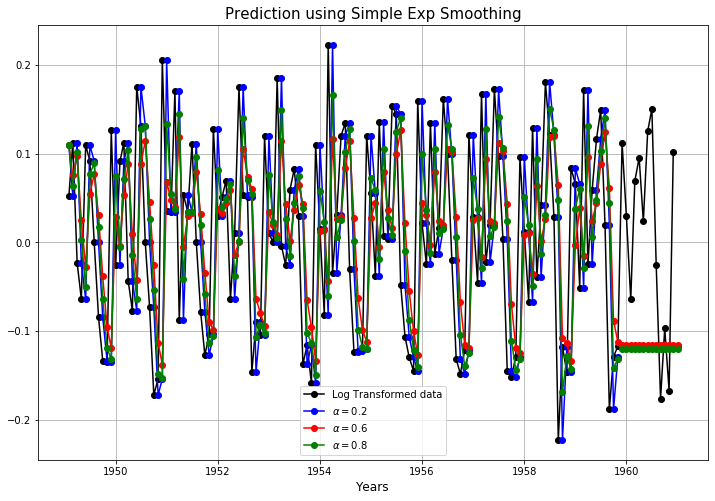

In [24]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Log Transformed data")
pyplot.plot(fit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.2$")
(line1,) = pyplot.plot(fcast1, marker="o", color="blue")
pyplot.plot(fit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
(line2,) = pyplot.plot(fcast2, marker="o", color="red")
pyplot.plot(fit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
(line3,) = pyplot.plot(fcast3, marker="o", color="green")
pyplot.title('Prediction using Simple Exp Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

rmse: 278.37715403866804
mae: 239.4500863981309


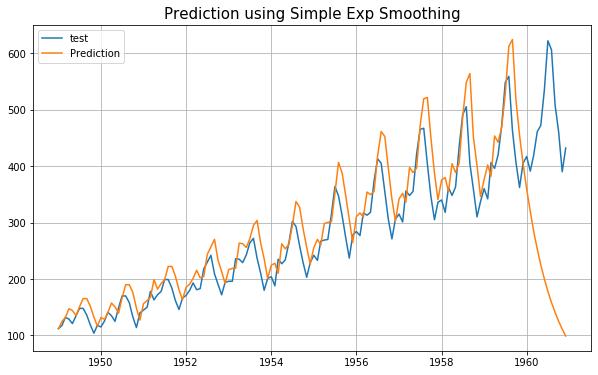

In [25]:
predictions_SimExp_diff = pd.Series(fit1.fittedvalues, copy=True)
predictions_SimExp_diff = predictions_SimExp_diff.append(fit1.forecast(test_size))
predictions_SimExp_diff_cumsum = predictions_SimExp_diff.cumsum()
predictions_SimExp_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_SimExp_log = predictions_SimExp_log.add(predictions_SimExp_diff_cumsum,fill_value=0)
predictions_SimExp = np.exp(predictions_SimExp_log)

pyplot.plot(df, label = "test")
pyplot.plot(predictions_SimExp[:-1], label = "Prediction")
pyplot.title('Prediction using Simple Exp Smoothing', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, predictions_SimExp.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_SimExp.iloc[130:-1])))

----------

### Question 2.2: Apply the HWES technique ([ExponentialSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
#Alpha = 0.2
expfit1 = ExponentialSmoothing(train_logm, 
                               initialization_method="heuristic").fit(smoothing_level=0.3, 
                                                                 optimized=False)
expfcast1 = expfit1.forecast(test_size).rename(r"$\alpha=0.2$")

#Alpha = 0.6                                                                 
expfit2 = ExponentialSmoothing(train_logm, 
                               initialization_method="heuristic").fit(smoothing_level=0.6, 
                                                                 optimized=False)
expfcast2 = expfit2.forecast(test_size).rename(r"$\alpha=0.6$")

#Alpha = 0.8                                                                   
expfit3 = ExponentialSmoothing(train_logm, 
                          initialization_method="heuristic").fit(smoothing_level=0.8, 
                                                                 optimized=False)
expfcast3 = expfit3.forecast(test_size).rename(r"$\alpha=0.8$")

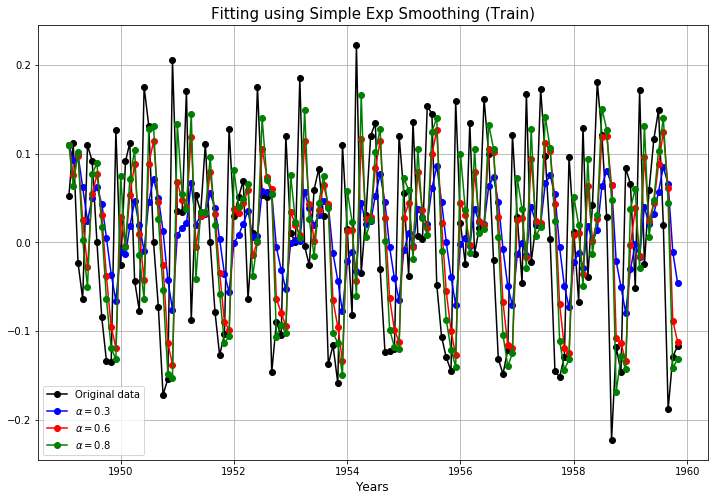

In [28]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(expfit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.3$")
pyplot.plot(expfit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
pyplot.plot(expfit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
pyplot.title('Fitting using Simple Exp Smoothing (Train)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

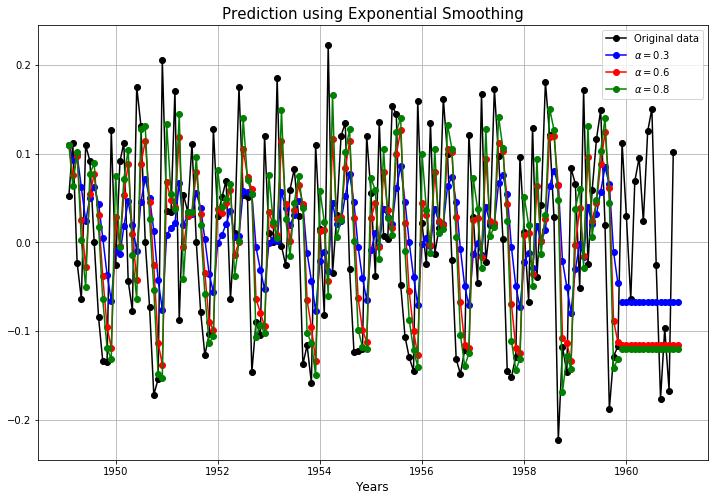

In [29]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(expfit1.fittedvalues, marker="o", color="blue", label = r"$\alpha=0.3$")
(line1,) = pyplot.plot(expfcast1, marker="o", color="blue")
pyplot.plot(expfit2.fittedvalues, marker="o", color="red", label = r"$\alpha=0.6$")
(line2,) = pyplot.plot(expfcast2, marker="o", color="red")
pyplot.plot(expfit3.fittedvalues, marker="o", color="green", label = r"$\alpha=0.8$")
(line3,) = pyplot.plot(expfcast3, marker="o", color="green")
pyplot.title('Prediction using Exponential Smoothing', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

rmse: 170.10965234661995
mae: 151.4059616108998


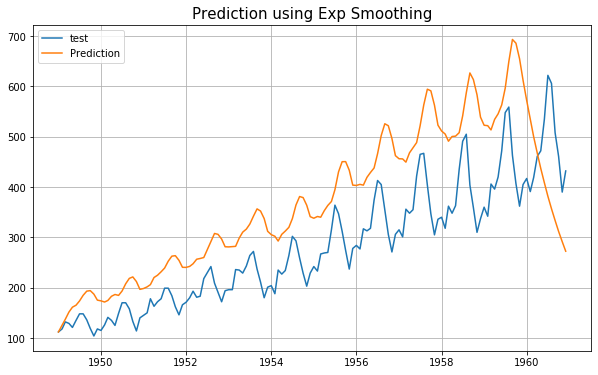

In [30]:
predictions_ExpSm_diff = pd.Series(expfit1.fittedvalues, copy=True)
predictions_ExpSm_diff = predictions_ExpSm_diff.append(expfit1.forecast(test_size))
predictions_ExpSm_diff_cumsum = predictions_ExpSm_diff.cumsum()
predictions_ExpSm_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ExpSm_log = predictions_ExpSm_log.add(predictions_ExpSm_diff_cumsum, fill_value=0)
predictions_ExpSm = np.exp(predictions_ExpSm_log)

pyplot.plot(df, label = "test")
pyplot.plot(predictions_ExpSm[:-1], label = "Prediction")
pyplot.title('Prediction using Exp Smoothing', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, predictions_ExpSm.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_ExpSm.iloc[130:-1])))

-----

# Autoregressive Moving Average Models

### Question 3.1: Apply Autoregression model ([AR](http://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [31]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random

In [32]:
AR_model = AR(train_logm)
AR_model_fit = AR_model.fit()

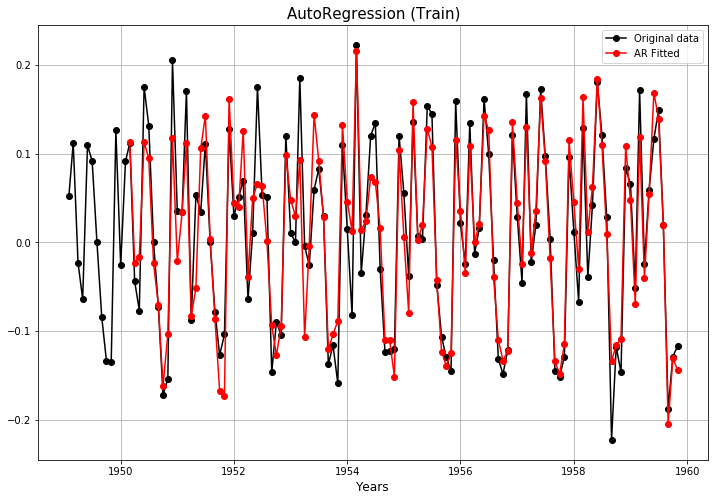

In [33]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(AR_model_fit.fittedvalues, marker="o", color='red', label = "AR Fitted")
pyplot.title('AutoRegression (Train)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [34]:
AR_predictions = AR_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

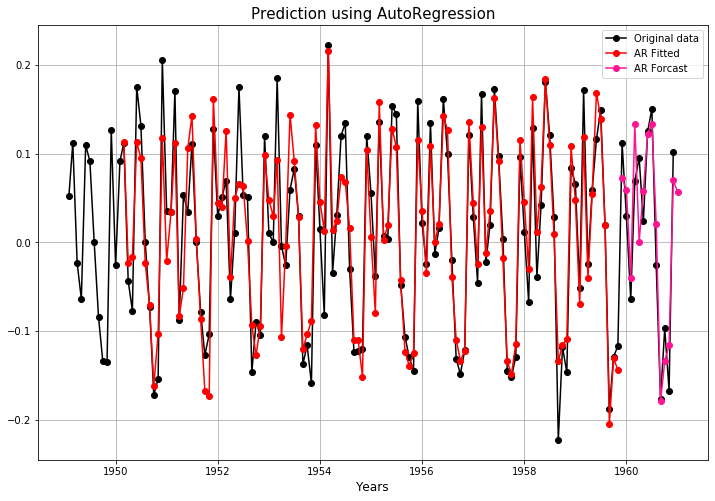

In [35]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(AR_model_fit.fittedvalues, marker="o", color='red', label = "AR Fitted")
pyplot.plot(AR_predictions, marker="o", color='deeppink', label = "AR Forcast")
pyplot.title('Prediction using AutoRegression', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

rmse: 45.7986772484709
mae: 43.76549981902225


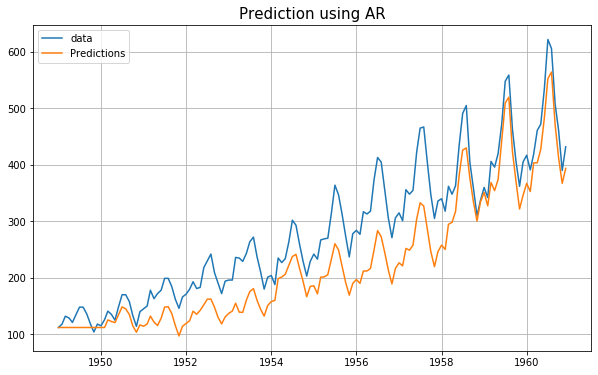

In [36]:
predictions_AR_diff = pd.Series(AR_model_fit.fittedvalues, copy=True)
predictions_AR_diff = predictions_AR_diff.append(AR_predictions)
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR = np.exp(predictions_AR_log)

pyplot.plot(df, label = "data")
pyplot.plot(predictions_AR[:-1], label = "Predictions")
pyplot.title('Prediction using AR', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, predictions_AR.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_AR.iloc[130:-1])))

----------

### Question 3.2: Apply Moving Average model [MA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [37]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA

# fit model
MA_model = ARMA(train_logm, order=(0, 1))
MA_model_fit = MA_model.fit(disp=False)

In [38]:
MA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  130
Model:                     ARMA(0, 1)   Log Likelihood                 110.688
Method:                       css-mle   S.D. of innovations              0.103
Date:                Fri, 10 Dec 2021   AIC                           -215.375
Time:                        10:41:24   BIC                           -206.773
Sample:                    02-01-1949   HQIC                          -211.880
                         - 11-01-1959                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0088      0.011      0.771      0.441      -0.014       0.031
ma.L1.passengers     0.2691      0.099      2.714      0.007       0.075       0.463
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -3.7158           +0.0000j            3.7158            0.5000
-----------------------------------------------------------------------------
"""

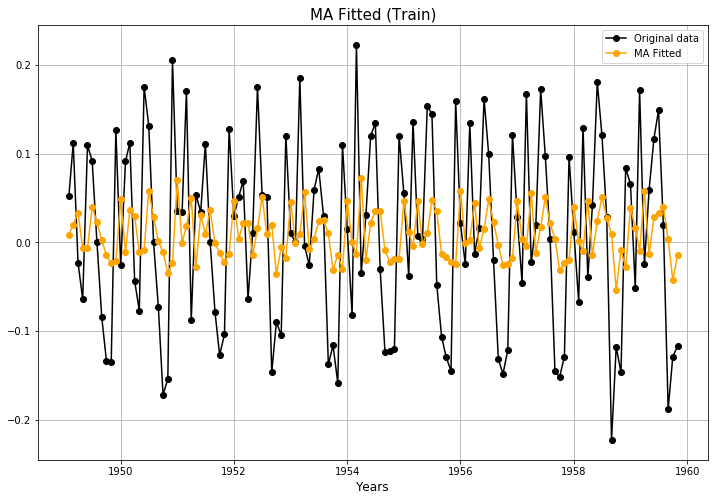

In [39]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train_logm, marker="o", color="black", label = "Original data")
pyplot.plot(MA_model_fit.fittedvalues, marker="o", color='orange', label = "MA Fitted")
pyplot.title('MA Fitted (Train)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [40]:
MA_predictions = MA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

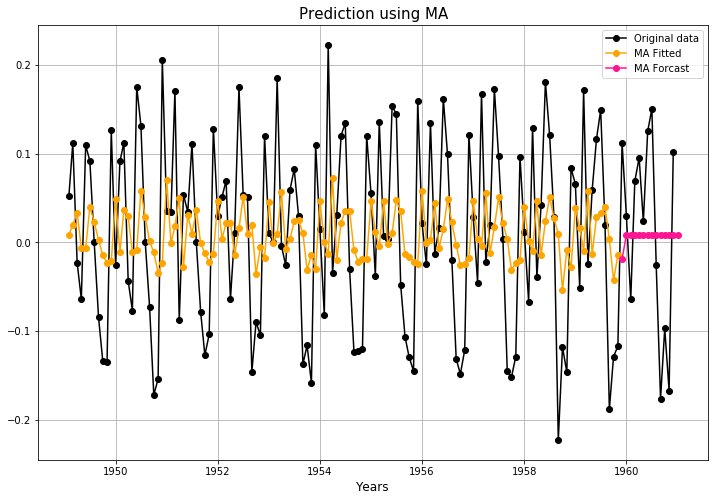

In [41]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(ts_log_diff, marker="o", color="black", label = "Original data")
pyplot.plot(MA_model_fit.fittedvalues, marker="o", color='orange', label = "MA Fitted")
pyplot.plot(MA_predictions, marker="o", color='deeppink', label = "MA Forcast")
pyplot.title('Prediction using MA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

#### Reversing Transformations

rmse: 114.59939257383405
mae: 88.5918597225819


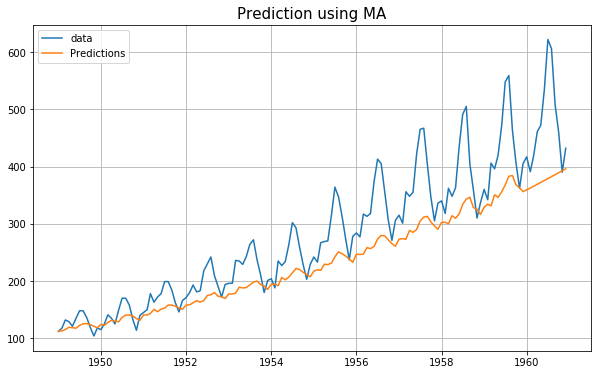

In [42]:
predictions_MA_diff = pd.Series(MA_model_fit.fittedvalues, copy=True)
predictions_MA_diff = predictions_MA_diff.append(MA_predictions)
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
predictions_MA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA = np.exp(predictions_MA_log)

pyplot.plot(df, label = "data")
pyplot.plot(predictions_MA[:-1], label = "Predictions")
pyplot.title('Prediction using MA', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, predictions_MA.iloc[130:-1]))))
print("mae: " + str(mean_absolute_error(test, predictions_MA.iloc[130:-1])))

----------

### Questio 4.1: Apply Autoregressive Moving Average model ([ARMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [43]:
ARMA_model = ARMA(train, order=(1, 1))
ARMA_model_fit = ARMA_model.fit(disp=False)

In [44]:
ARMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  130
Model:                     ARMA(1, 1)   Log Likelihood                -622.347
Method:                       css-mle   S.D. of innovations             28.711
Date:                Fri, 10 Dec 2021   AIC                           1252.694
Time:                        10:41:26   BIC                           1264.164
Sample:                    01-01-1949   HQIC                          1257.355
                         - 10-01-1959                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              259.7726     46.624      5.572      0.000     168.392     351.153
ar.L1.passengers     0.9297      0.034     27.721      0.000       0.864       0.995
ma.L1.passengers     0.4306      0.097      4.427      0.000       0.240       0.621
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0756           +0.0000j            1.0756            0.0000
MA.1           -2.3222           +0.0000j            2.3222            0.5000
-----------------------------------------------------------------------------
"""

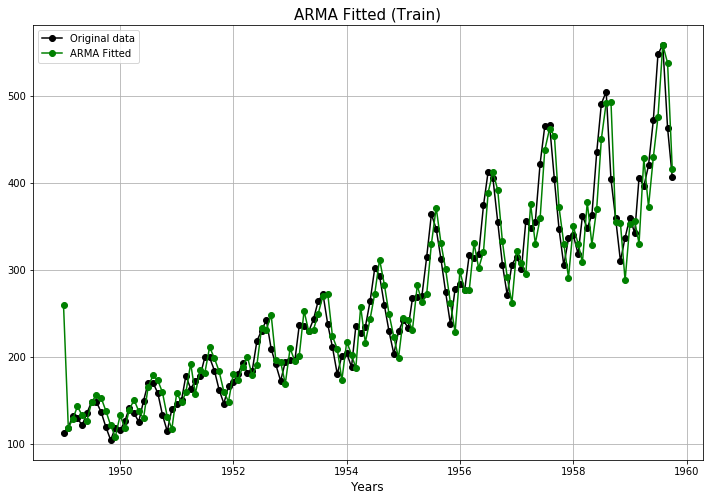

In [45]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train, marker="o", color="black", label = "Original data")
pyplot.plot(ARMA_model_fit.fittedvalues, marker="o", color='green', label = "ARMA Fitted")
pyplot.title('ARMA Fitted (Train)', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [46]:
ARMA_predictions = ARMA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

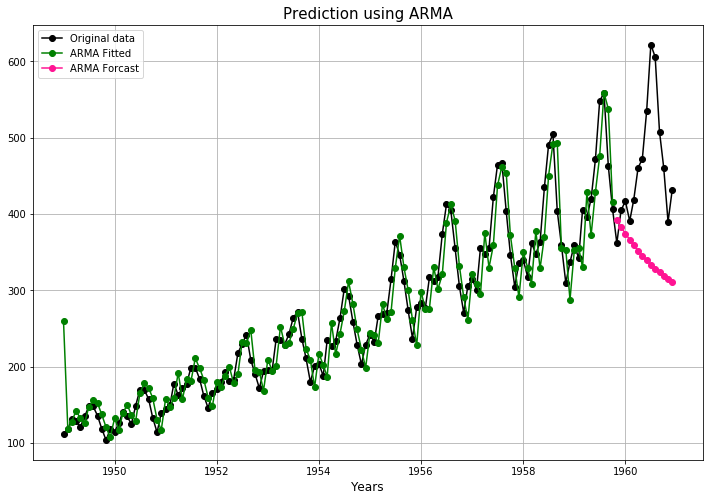

In [47]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(df, marker="o", color="black", label = "Original data")
pyplot.plot(ARMA_model_fit.fittedvalues, marker="o", color='green', label = "ARMA Fitted")
pyplot.plot(ARMA_predictions, marker="o", color='deeppink', label = "ARMA Forcast")
pyplot.title('Prediction using ARMA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [48]:
print("rmse: " + str(sqrt(mean_squared_error(test, ARMA_predictions))))
print("mae: " + str(mean_absolute_error(test, ARMA_predictions)))

rmse: 148.21630406370087
mae: 121.21371736324923


----------

### Question 4.2: Apply Autoregressive Integrated Moving Average model ([ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html) API) to the airline dataset and report the prediction accuracy (RMSE and MAE) on the test dataset. Try to play around with the hyper-parameters in the API and see how it impacts the model accuracy. 

In [49]:
from statsmodels.tsa.arima_model import ARIMA
ARIMA_model = ARIMA(train, order=(2,0,1))
ARIMA_model_fit = ARIMA_model.fit(disp=1)

In [50]:
ARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             passengers   No. Observations:                  130
Model:                     ARMA(2, 1)   Log Likelihood                -618.713
Method:                       css-mle   S.D. of innovations             27.821
Date:                Fri, 10 Dec 2021   AIC                           1247.427
Time:                        10:41:26   BIC                           1261.764
Sample:                    01-01-1949   HQIC                          1253.252
                         - 10-01-1959                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              259.5664     54.046      4.803      0.000     153.638     365.495
ar.L1.passengers     0.4216      0.101      4.177      0.000       0.224       0.619
ar.L2.passengers     0.5017      0.102      4.922      0.000       0.302       0.701
ma.L1.passengers     0.9335      0.052     18.089      0.000       0.832       1.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0529           +0.0000j            1.0529            0.0000
AR.2           -1.8932           +0.0000j            1.8932            0.5000
MA.1           -1.0713           +0.0000j            1.0713            0.5000
-----------------------------------------------------------------------------
"""

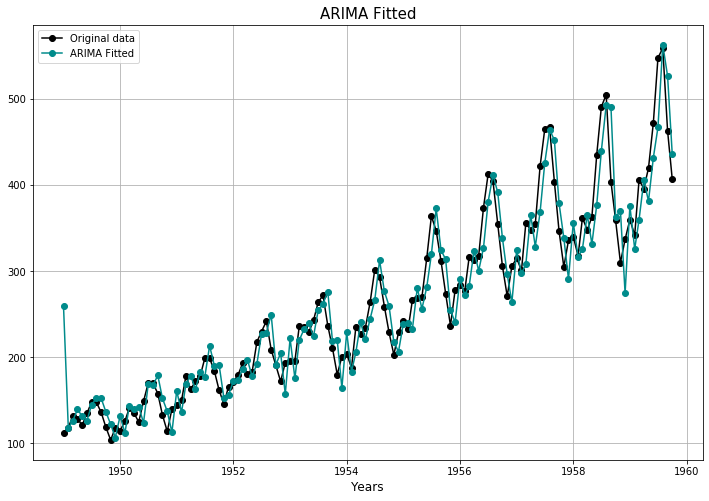

In [51]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train, marker="o", color="black", label = "Original data")
pyplot.plot(ARIMA_model_fit.fittedvalues, marker="o", color='darkcyan', label = "ARIMA Fitted")
pyplot.title('ARIMA Fitted', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [52]:
ARIMA_predictions = ARIMA_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

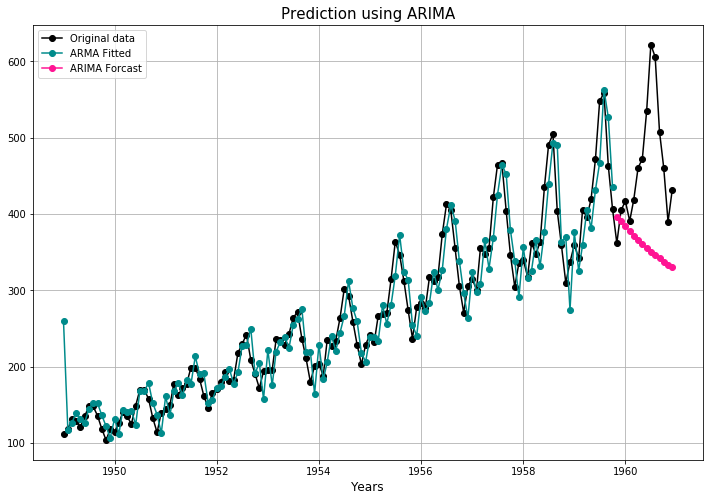

In [53]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(df, marker="o", color="black", label = "Original data")
pyplot.plot(ARIMA_model_fit.fittedvalues, marker="o", color='darkcyan', label = "ARMA Fitted")
pyplot.plot(ARIMA_predictions, marker="o", color='deeppink', label = "ARIMA Forcast")
pyplot.title('Prediction using ARIMA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [54]:
print("rmse: " + str(sqrt(mean_squared_error(test, ARIMA_predictions))))
print("mae: " + str(mean_absolute_error(test, ARIMA_predictions)))

rmse: 135.043635377237
mae: 107.42952396553517


----------

### Question 4.3: Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [55]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
SARIMAX_model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 2, 3, 4))
SARIMAX_model_fit = SARIMAX_model.fit(disp=False)

C:\Users\ly266e\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [56]:
SARIMAX_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  130
Model:             SARIMAX(3, 1, 3)x(1, 2, 3, 4)   Log Likelihood                -567.974
Date:                           Fri, 10 Dec 2021   AIC                           1157.949
Time:                                   10:41:30   BIC                           1188.703
Sample:                               01-01-1949   HQIC                          1170.439
                                    - 10-01-1959                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0012      0.236     -0.005      0.996      -0.463       0.461
ar.L2          0.0025      0.232      0.011      0.991      -0.452       0.457
ar.L3         -0.9963      0.232     -4.298      0.000      -1.451      -0.542
ma.L1          0.1642     44.711      0.004      0.997     -87.467      87.796
ma.L2          0.1650     51.951      0.003      0.997    -101.657     101.987
ma.L3          0.9996     54.553      0.018      0.985    -105.923     107.922
ar.S.L4       -0.6644      0.155     -4.277      0.000      -0.969      -0.360
ma.S.L4       -0.9834     54.392     -0.018      0.986    -107.589     105.622
ma.S.L8       -0.9861      1.773     -0.556      0.578      -4.462       2.489
ma.S.L12       0.9713     53.125      0.018      0.985    -103.152     105.095
sigma2       435.1084      0.224   1944.059      0.000     434.670     435.547
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.53
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               6.10   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.01e+21. Standard errors may be unstable.
"""

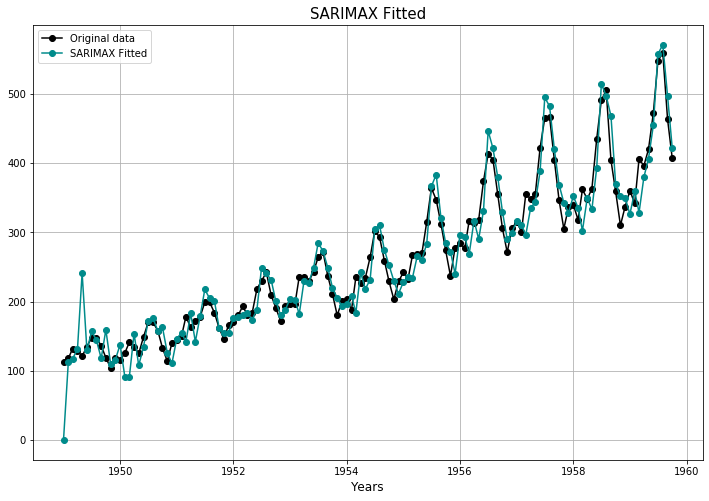

In [57]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(train, marker="o", color="black", label = "Original data")
pyplot.plot(SARIMAX_model_fit.fittedvalues, marker="o", color='darkcyan', label = "SARIMAX Fitted")
pyplot.title('SARIMAX Fitted', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [58]:
SARIMAX_predictions = SARIMAX_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

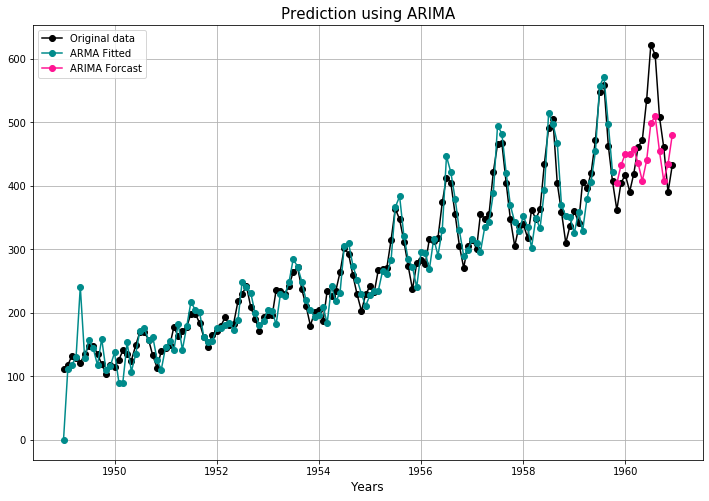

In [59]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(df, marker="o", color="black", label = "Original data")
pyplot.plot(SARIMAX_model_fit.fittedvalues, marker="o", color='darkcyan', label = "ARMA Fitted")
pyplot.plot(SARIMAX_predictions, marker="o", color='deeppink', label = "ARIMA Forcast")
pyplot.title('Prediction using ARIMA', fontsize = 15)
pyplot.xlabel('Years', fontsize = 12)
pyplot.grid()
pyplot.legend()

In [60]:
print("rmse: " + str(sqrt(mean_squared_error(test, SARIMAX_predictions))))
print("mae: " + str(mean_absolute_error(test, SARIMAX_predictions)))

rmse: 63.867657997048454
mae: 57.571180671188465


----------

### Question 4.4: Apply AUTO ARIMA Model

In [61]:
from pmdarima.arima import auto_arima
stepwise = auto_arima(train, start_p=1, start_q=1,
                             max_p=3, max_q=3, max_P=3, m=12, #m -> the number of observations per cycle
                             start_P=1, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
stepwise.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=889.536, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=885.283, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=886.316, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=884.180, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=885.485, Time=0.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=885.371, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=884.919, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=885.131, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=886.905, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=885.916, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.750 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  130
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -440.090
Date:                            Fri, 10 Dec 2021   AIC                            884.180
Time:                                    10:41:34   BIC                            889.704
Sample:                                         0   HQIC                           886.423
                                            - 130                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2471      0.090     -2.752      0.006      -0.423      -0.071
sigma2       108.2557     13.261      8.163      0.000      82.264     134.248
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.86   Prob(JB):                         0.73
Heteroskedasticity (H):               1.41   Skew:                            -0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
stepwise.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [63]:
forecast = stepwise.predict(n_periods=14)
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

rmse: 15.17562191619455
mae: 11.14009948463277


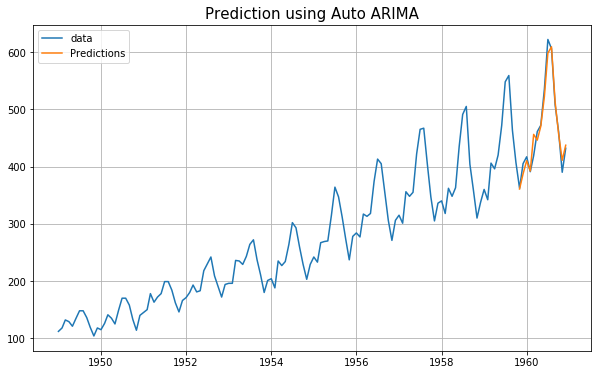

In [65]:
pyplot.plot(df, label = "data")
pyplot.plot(forecast, label = "Predictions")
pyplot.title('Prediction using Auto ARIMA', fontsize = 15)
pyplot.grid()
pyplot.legend()

print("rmse: " + str(sqrt(mean_squared_error(test, forecast))))
print("mae: " + str(mean_absolute_error(test, forecast)))

### Question 5: After running through various time series models, summarize your findings. 

| Model| RMSE | MAE |
| --- | --- | --- | 
| Simple Exp | 278.37 | 239.45 | 
| Exp Smoothing | 170.109 | 151.405 | 
| Auto-Regression | 45.79 | 43.76 | 
| Moving Average | 114.59 | 88.59 | 
| ARMA | 148.21 | 121.21 | 
| ARIMA | 135.04 | 107.42 | 
| SARIMA | 63.86 | 57.57 | 
| Auto ARIMA | 15.17 | 11.14 | 

----------

### Question 6. Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. 


**Summary:**

- I do not have a lot of experience working with forecasting, but after this assignment I can definitely agree with the statement we saw in class: *It's Difficult to Make Predictions, Especially About the Future (Niels Bohr)*

- Thru this assignment it was possible to notice how some of the models do a good job for this dataset, while other do not as some of the models that we worked with here work under the assumption of *STATIONARY* data or the assumption of no-trend. While this is a limitation there are ways to work around this by transforming the data in stable and *NON-STATIONARY* trend.



**Quick re-cap of the analysis above:**


- The Time Series for the `Airline Passengers` production was found **NON-STATIONARY** as the variation of the residual values grow over time.

- In the case of the `Airline Passengers` dataset it is seen a strong seasonal effect along with with an up trend. Note: This seasonal effect was expected as people tend to travel more during the hotter months (around summer).

- The STL decomposition of the time series was performed with the multiplicative model. This since the Residuals for the variable analyzed (`Airline Passengers`) was found **NON-STATIONARY**.


**Regarding the Predictions:**


- For this particular analysis the 3 best models where: `AutoRegression (AR)`, `SARIMA` & `Auto ARIMA`.
- Much more analysis could be done to improve the forecasting like: improving the hyperparameters selections and/or do other data transformations, but as for this exploratory analysis it can be seen that depending on each of the methods and underlying assumptions some perform better than others even with further exploration.